# Sentiment Analysis of Amazon Reviews
# --- Hai Dang Vu (29348938) ---

## 1. Import necessary libraries

In [19]:
import os
import numpy as np
import pandas as pd
from scipy.stats import loguniform
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    auc,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier

from gensim.models import Word2Vec

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Download required NLTK resources
nltk.download("punkt")

[nltk_data] Downloading package punkt to C:\Users\tamqu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Prepare data

In [20]:
# Load dataset
df = pd.read_csv('amazon_reviews.csv')

# Handle missing values
initial_count = len(df)
df = df.dropna(subset=["cleaned_review"])
print(f"Removed {initial_count - len(df)} rows with missing values")

# Remove duplicates
print('Initial duplicate count:', df.duplicated().sum())
df = df.drop_duplicates(subset=['cleaned_review', 'sentiments'])
print('Remaining duplicate count:', df.duplicated().sum())

# Prepare features and target
X = df['cleaned_review']
y = df['sentiments']

# Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Stratified split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

Removed 3 rows with missing values
Initial duplicate count: 1347
Remaining duplicate count: 0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13193 entries, 0 to 17339
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sentiments             13193 non-null  object 
 1   cleaned_review         13193 non-null  object 
 2   cleaned_review_length  13193 non-null  int64  
 3   review_score           13193 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 515.4+ KB


## 3. Helper functions, variables

#### Function to plot roc curve

In [22]:
def plot_roc_curve(y_test, y_score, class_names, title):
    # ROC plotting for multi-class
    # Binarize the test labels (for 3 classes)
    y_test_bin = label_binarize(y_test, classes=list(range(len(class_names))))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        plt.plot(
            fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})"
        )
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
        linestyle="--",
    )
    plt.plot([0, 1], [0, 1], "k:", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

#### Function to evaluate a model

In [23]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names=None):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions on the training set
    y_pred_train = model.predict(X_train)
    y_pred_prob_train = model.predict_proba(X_train)  # returns a list of 3 arrays
    # Make predictions on the test set
    y_pred_test = model.predict(X_test)
    y_pred_prob_test = model.predict_proba(X_test)  # returns a list of 3 arrays

    # Calculate metrics for training set
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(
        y_train, y_pred_train, average="weighted"
    )  # Use 'weighted' to account for class imbalance
    train_recall = recall_score(
        y_train, y_pred_train, average="weighted"
    )  # Use 'weighted' to account for class imbalance
    train_f1 = f1_score(
        y_train, y_pred_train, average="weighted"
    )  # Use 'weighted' to account for class imbalance
    train_roc_auc = roc_auc_score(y_train, y_pred_prob_train, multi_class="ovr")

    # Calculate metrics for test set
    test_accuracy = accuracy_score(
        y_test, y_pred_test
    )  # Use 'weighted' to account for class imbalance
    test_precision = precision_score(
        y_test, y_pred_test, average="weighted"
    )  # Use 'weighted' to account for class imbalance
    test_recall = recall_score(
        y_test, y_pred_test, average="weighted"
    )  # Use 'weighted' to account for class imbalance
    test_f1 = f1_score(
        y_test, y_pred_test, average="weighted"
    )  # Use 'weighted' to account for class imbalance
    test_roc_auc = roc_auc_score(y_test, y_pred_prob_test, multi_class="ovr")

    # Print the ROC AUC scores
    print(f"Train ROC AUC: {train_roc_auc:.4f}")
    print(f"Test ROC AUC: {test_roc_auc :.4f}")

    # Print the classification report for training set
    print("Classification report on train set:")
    print(classification_report(y_train, y_pred_train))
    # Plot ROC curve for training set
    plot_roc_curve(
        y_train,
        y_pred_prob_train,
        class_names,
        title="ROC Curve (One-vs-Rest) - Train Set",
    )

    # Plot confusion matrix for training set
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(
        model, X_train, y_train, cmap="Blues", display_labels=class_names
    )
    plt.title("Confusion Matrix - Train Set")
    plt.show()

    # Print the classification report for test set
    print("Classification report on test set:")
    print(classification_report(y_test, y_pred_test))
    # Plot ROC curve for test set
    plot_roc_curve(
        y_test,
        y_pred_prob_test,
        class_names,
        title="ROC Curve (One-vs-Rest) - Test Set",
    )
    # Plot confusion matrix for test set
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap="Blues", display_labels=class_names
    )
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    return [
        train_accuracy,
        train_precision,
        train_recall,
        train_f1,
        train_roc_auc,
        test_accuracy,
        test_precision,
        test_recall,
        test_f1,
        test_roc_auc,
    ]

#### A data frame to store the metrics of different models

In [24]:
score = pd.DataFrame(
    index=[
        "Train Accuracy",
        "Train Precision",
        "Train Recall",
        "Train F1",
        "Train ROC AUC",
        "Test Accuracy",
        "Test Precision",
        "Test Recall",
        "Test F1",
        "Test ROC AUC",
    ]
)

#### Custom tokenize function with stemming

In [25]:
# Import the Porter stemmer from NLTK
stemmer = PorterStemmer()


# Define a custom tokenizer function that stems each token
def stem_tokenizer(text):
    try:
        # Tokenize the input text into individual words
        tokens = word_tokenize(text)
        # Apply stemming to each token and return the list of stemmed tokens
        return [stemmer.stem(token) for token in tokens]
    except:
        # In case of an error (text is None or not a string), return an empty list
        return []

## 4. Solutions

### 4.1 Solution 1: Applying Embedding-based techniques (Word2Vec, GloVe)

**GloVe - Global Vectors for Word Representation**

In [26]:
# Load GloVe embeddings
# Download from: http://nlp.stanford.edu/data/glove.6B.zip
# Unzip and point GLOVE_PATH at glove.6B.300d.txt
GLOVE_PATH = "glove.6B.300d.txt"


def load_glove(glove_path):
    emb_index = {}
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            vec = np.asarray(parts[1:], dtype="float32")
            emb_index[word] = vec
    return emb_index


class GloveVectorizer(BaseEstimator, TransformerMixin):
    """
    Transformer that takes in an iterable of token lists and returns
    the corresponding average GloVe embeddings.
    """

    def __init__(self, emb_index, dim=300):
        self.emb_index = emb_index
        self.dim = dim

    def fit(self, X, y=None):
        # nothing to learn
        return self

    def transform(self, X):
        # X is assumed to be an iterable (list or Series) of token lists
        def avg_embed(tokens):
            vecs = [self.emb_index[w] for w in tokens if w in self.emb_index]
            if vecs:
                return np.mean(vecs, axis=0)
            else:
                return np.zeros(self.dim, dtype="float32")

        # apply and stack into a 2D array
        return np.vstack([avg_embed(toks) for toks in X])


# Tokenize and stem the 'cleaned_review' column
df["tokens"] = df["cleaned_review"].apply(stem_tokenizer)

print("Loading GloVe embeddings (this may take a minute)…")
glove_index = load_glove(GLOVE_PATH)
EMB_DIM = 300
print(f"  → loaded {len(glove_index)} word vectors.")

# Because this method uses tokens (tokenized from clean_review), I created a complete new set of variables
X_glove = df["tokens"]  # raw tokens column
y_glove = df["sentiments"]  # labels
y_glove_encoded = le.fit_transform(y_glove)

# Stratified split based on y_glove_encoded
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(
    X_glove, y_glove_encoded, test_size=0.2, random_state=42, stratify=y_glove_encoded
)



Loading GloVe embeddings (this may take a minute)…
  → loaded 400000 word vectors.


Train ROC AUC: 0.8731
Test ROC AUC: 0.8427
Classification report on train set:
              precision    recall  f1-score   support

           0       0.58      0.14      0.22       884
           1       0.64      0.65      0.64      3623
           2       0.80      0.87      0.83      6047

    accuracy                           0.74     10554
   macro avg       0.67      0.55      0.57     10554
weighted avg       0.72      0.74      0.72     10554



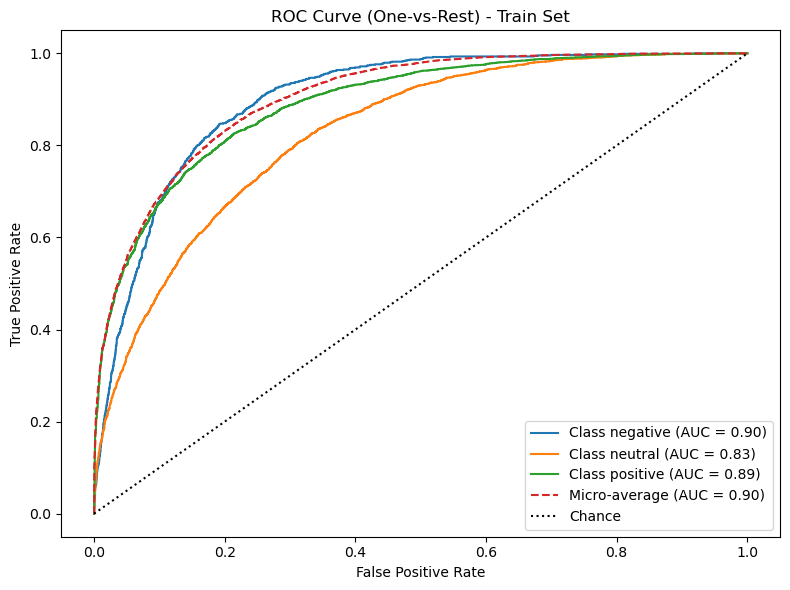

<Figure size 800x600 with 0 Axes>

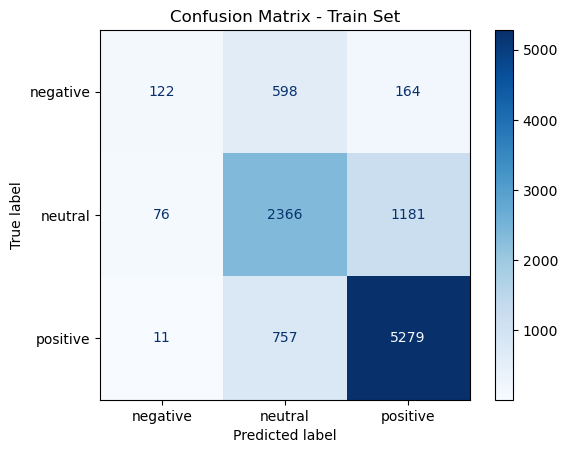

Classification report on test set:
              precision    recall  f1-score   support

           0       0.49      0.14      0.21       221
           1       0.59      0.60      0.60       906
           2       0.78      0.86      0.82      1512

    accuracy                           0.71      2639
   macro avg       0.62      0.53      0.54      2639
weighted avg       0.69      0.71      0.69      2639



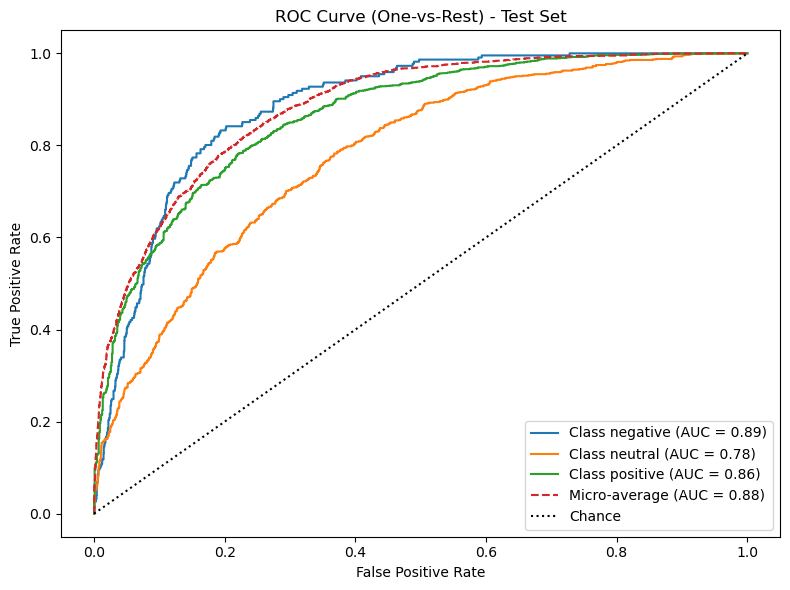

<Figure size 800x600 with 0 Axes>

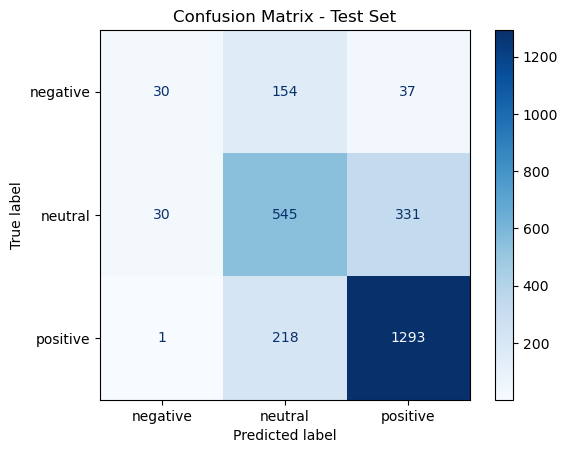

In [27]:
pipeline = ImbPipeline(
    [
        ("embed", GloveVectorizer(glove_index, dim=300)),
        # ("smote", SMOTE(random_state=42)),
        (
            "clf",
            LogisticRegression(max_iter=1000),
        ),
    ]
)

score["GloVe + LR"] = evaluate_model(
    pipeline,
    X_train_glove,
    y_train_glove,
    X_test_glove,
    y_test_glove,
    class_names=le.classes_,
)

c:\Users\tamqu\anaconda3\envs\study\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train ROC AUC: 0.9999
Test ROC AUC: 0.8381
Classification report on train set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       884
           1       1.00      1.00      1.00      3623
           2       1.00      1.00      1.00      6047

    accuracy                           1.00     10554
   macro avg       1.00      1.00      1.00     10554
weighted avg       1.00      1.00      1.00     10554



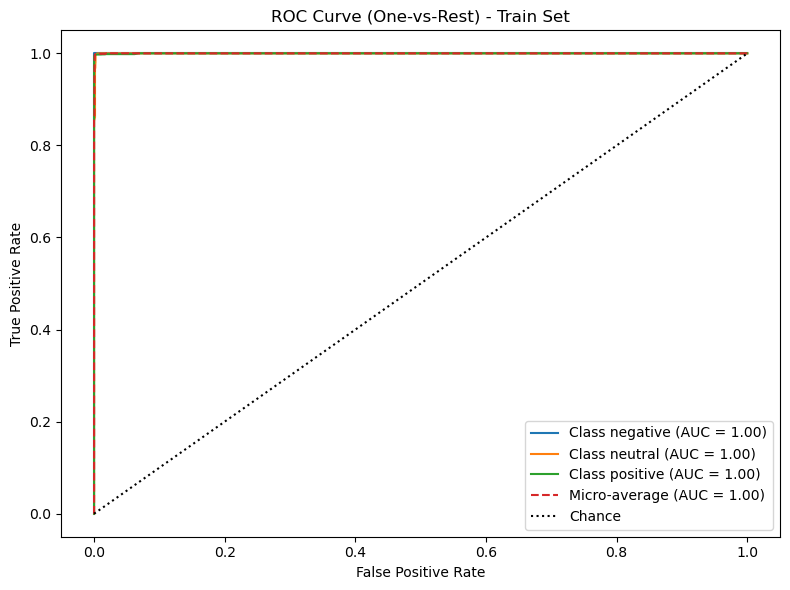

<Figure size 800x600 with 0 Axes>

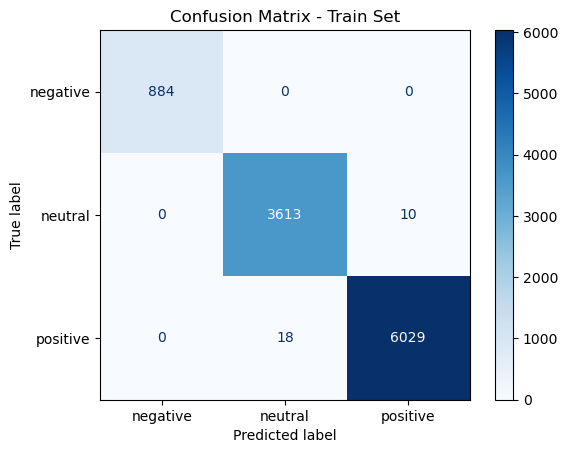

Classification report on test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       221
           1       0.67      0.64      0.65       906
           2       0.77      0.90      0.83      1512

    accuracy                           0.73      2639
   macro avg       0.48      0.51      0.49      2639
weighted avg       0.67      0.73      0.70      2639



c:\Users\tamqu\anaconda3\envs\study\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tamqu\anaconda3\envs\study\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tamqu\anaconda3\envs\study\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


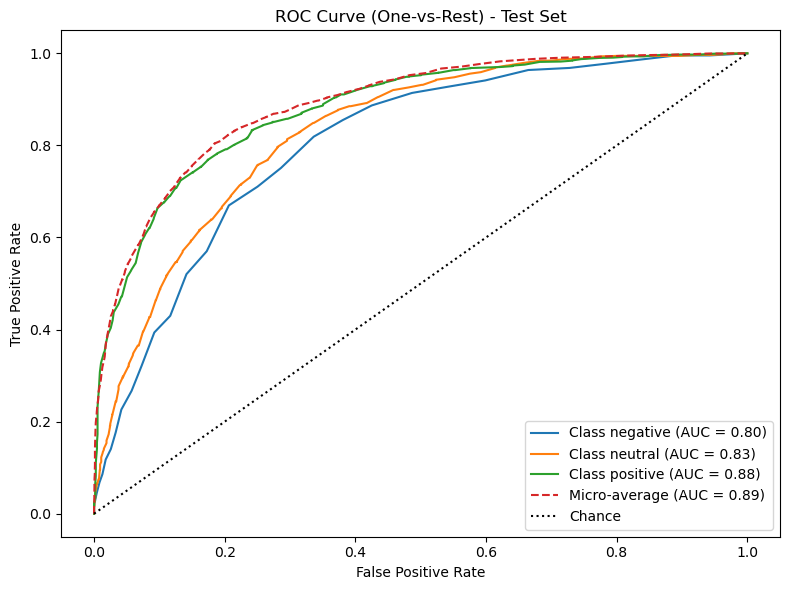

<Figure size 800x600 with 0 Axes>

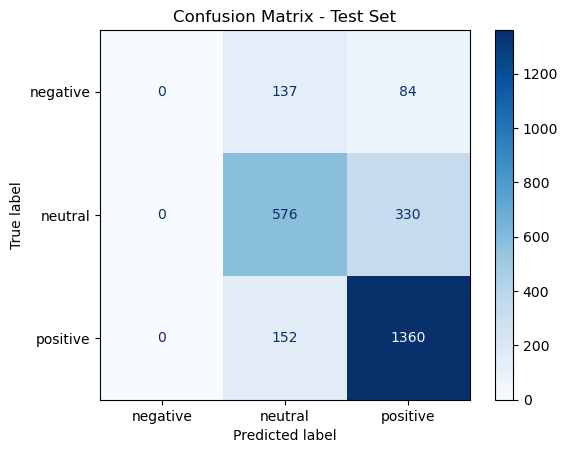

In [28]:
pipeline = ImbPipeline(
    [
        ("embed", GloveVectorizer(glove_index, dim=300)),
        # ("smote", SMOTE(random_state=42)),
        (
            "clf",
            RandomForestClassifier(random_state=42),
        ),
    ]
)

score["GloVe + RF"] = evaluate_model(
    pipeline,
    X_train_glove,
    y_train_glove,
    X_test_glove,
    y_test_glove,
    class_names=le.classes_,
)

**Word2Vec**

In [29]:
df["tokens"] = df["cleaned_review"].apply(stem_tokenizer)

# Train Word2Vec
W2V_DIM = 300
w2v_model = Word2Vec(
    sentences=df["tokens"],
    vector_size=W2V_DIM,
    window=5,
    min_count=2,
    workers=os.cpu_count(),
    seed=42,
)


# Define the custom transformer using Word2Vec
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model, dim=300):
        self.model = model
        self.dim = dim

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def avg_embed(tokens):
            vecs = [self.model.wv[w] for w in tokens if w in self.model.wv]
            return np.mean(vecs, axis=0) if vecs else np.zeros(self.dim)

        return np.vstack([avg_embed(toks) for toks in X])


# Prepare data
X_w2v = df["tokens"]
y_w2v = df["sentiments"]
y_w2v_encoded = le.fit_transform(y_w2v)

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v, y_w2v_encoded, test_size=0.2, random_state=42, stratify=y_w2v_encoded
)

Train ROC AUC: 0.8956
Test ROC AUC: 0.8591
Classification report on train set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       884
           1       0.69      0.72      0.70      3623
           2       0.81      0.91      0.86      6047

    accuracy                           0.77     10554
   macro avg       0.50      0.54      0.52     10554
weighted avg       0.70      0.77      0.73     10554



c:\Users\tamqu\anaconda3\envs\study\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tamqu\anaconda3\envs\study\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tamqu\anaconda3\envs\study\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\User

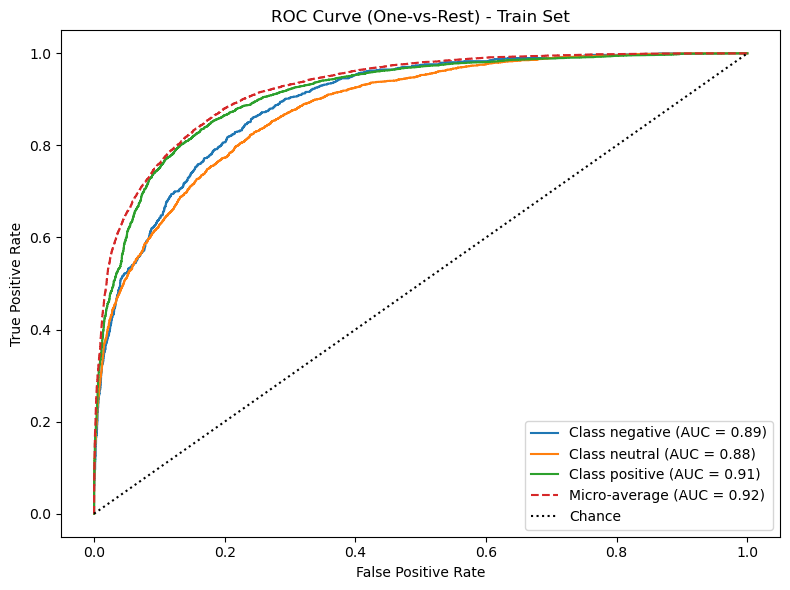

<Figure size 800x600 with 0 Axes>

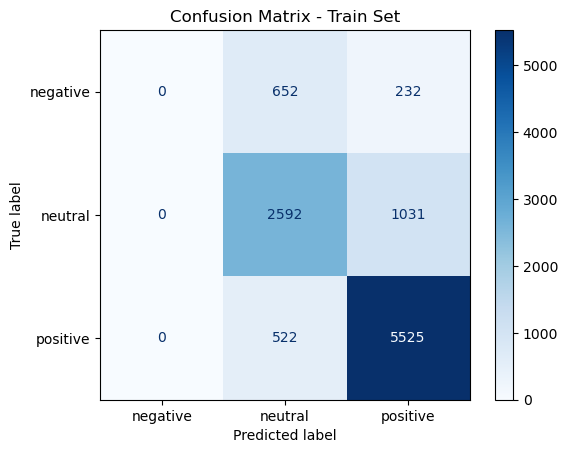

Classification report on test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       221
           1       0.65      0.67      0.66       906
           2       0.78      0.89      0.83      1512

    accuracy                           0.74      2639
   macro avg       0.48      0.52      0.50      2639
weighted avg       0.67      0.74      0.70      2639



c:\Users\tamqu\anaconda3\envs\study\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tamqu\anaconda3\envs\study\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tamqu\anaconda3\envs\study\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


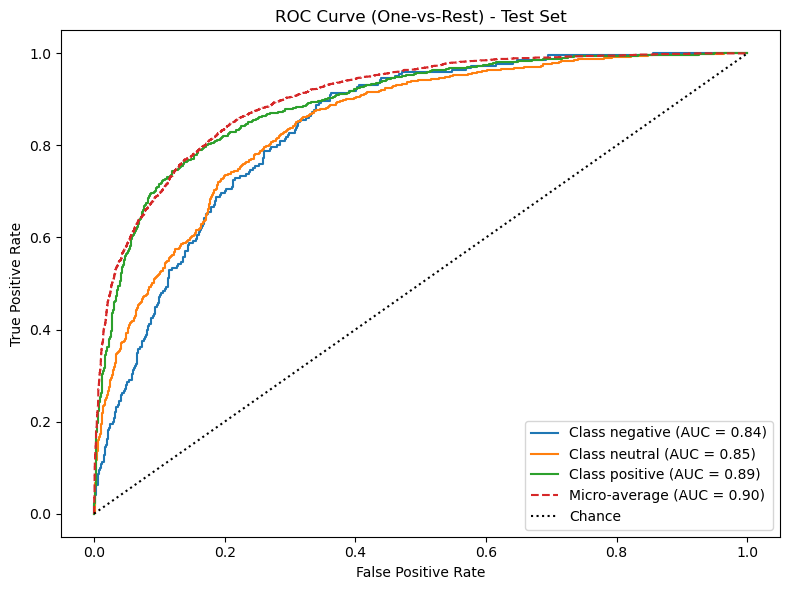

<Figure size 800x600 with 0 Axes>

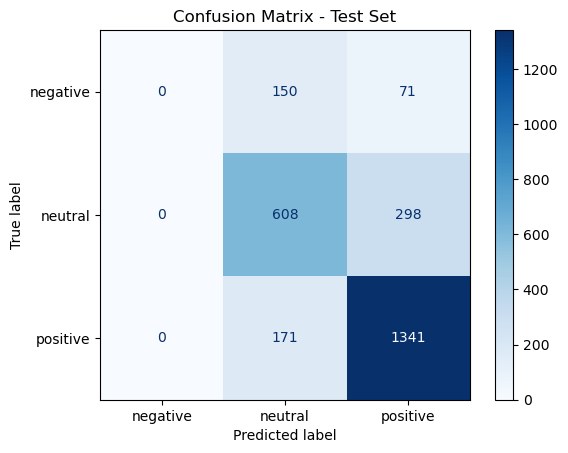

In [30]:
pipeline = ImbPipeline(
    [
        ("embed", Word2VecVectorizer(w2v_model, dim=W2V_DIM)),
        # ("smote", SMOTE(random_state=42)),
        (
            "clf",
            SVC(probability=True, random_state=42),
        ),
    ]
)

score["W2V + SVM"] = evaluate_model(
    pipeline,
    X_train_w2v,
    y_train_w2v,
    X_test_w2v,
    y_test_w2v,
    class_names=le.classes_,
)

Train ROC AUC: 1.0000
Test ROC AUC: 0.8563
Classification report on train set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       884
           1       1.00      1.00      1.00      3623
           2       1.00      1.00      1.00      6047

    accuracy                           1.00     10554
   macro avg       1.00      1.00      1.00     10554
weighted avg       1.00      1.00      1.00     10554



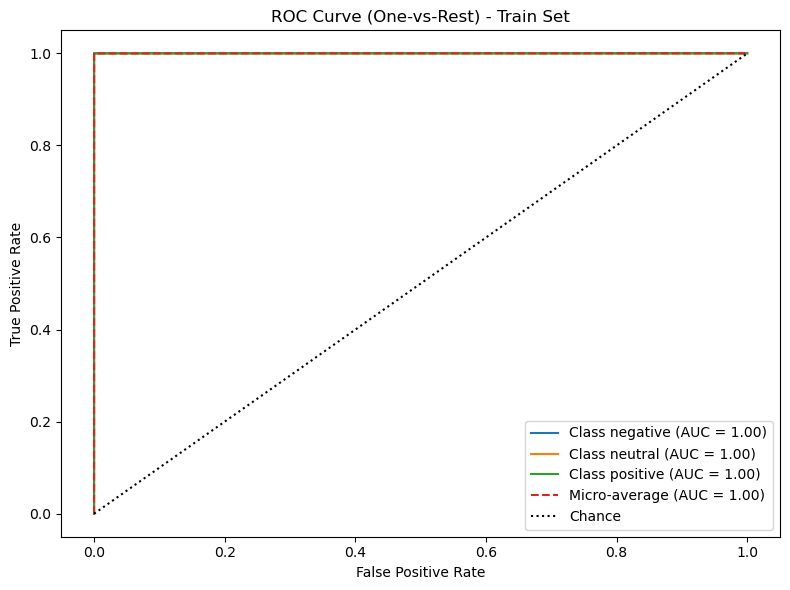

<Figure size 800x600 with 0 Axes>

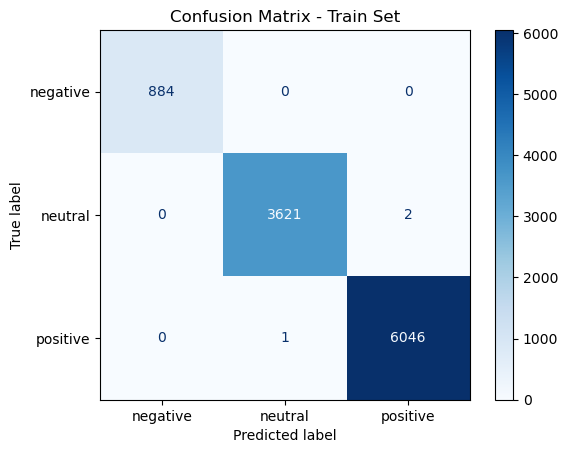

Classification report on test set:
              precision    recall  f1-score   support

           0       0.31      0.08      0.13       221
           1       0.63      0.67      0.65       906
           2       0.80      0.86      0.83      1512

    accuracy                           0.73      2639
   macro avg       0.58      0.54      0.54      2639
weighted avg       0.70      0.73      0.71      2639



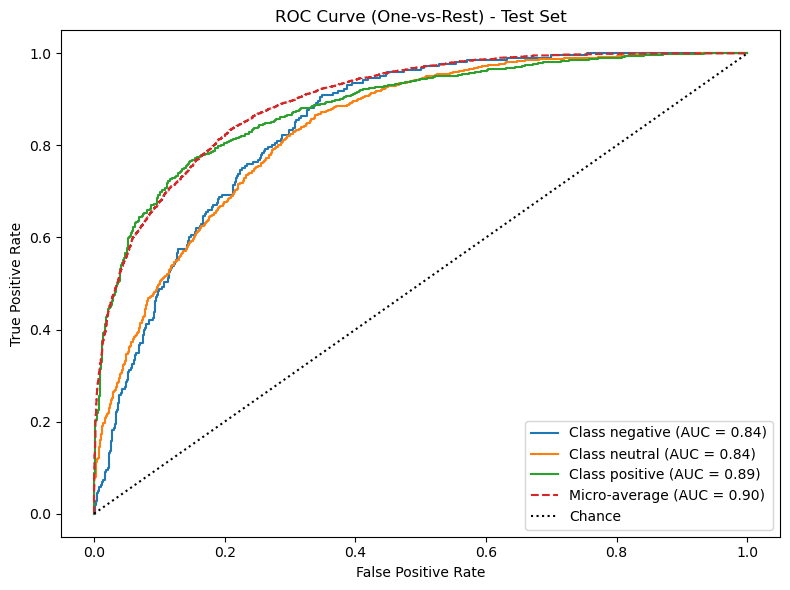

<Figure size 800x600 with 0 Axes>

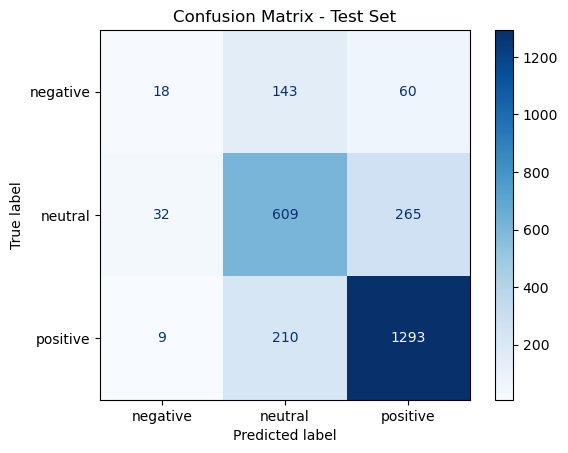

In [31]:
pipeline = ImbPipeline(
    [
        ("embed", Word2VecVectorizer(w2v_model, dim=W2V_DIM)),
        # ("smote", SMOTE(random_state=42)),
        (
            "clf",
            XGBClassifier(),
        ),
    ]
)

score["W2V + XGBoost"] = evaluate_model(
    pipeline,
    X_train_w2v,
    y_train_w2v,
    X_test_w2v,
    y_test_w2v,
    class_names=le.classes_,
)

### 4.1 Solution 2: Applying Statistical, Contextual techniques (BoW, N-grams, TF-IDF)

**Logistic Regression**

Starting randomized grid search...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best model evaluation:
Train ROC AUC: 0.9677
Test ROC AUC: 0.9223
Classification report on train set:
              precision    recall  f1-score   support

           0       0.61      0.90      0.73       884
           1       0.84      0.82      0.83      3623
           2       0.95      0.90      0.92      6047

    accuracy                           0.87     10554
   macro avg       0.80      0.87      0.83     10554
weighted avg       0.89      0.87      0.88     10554



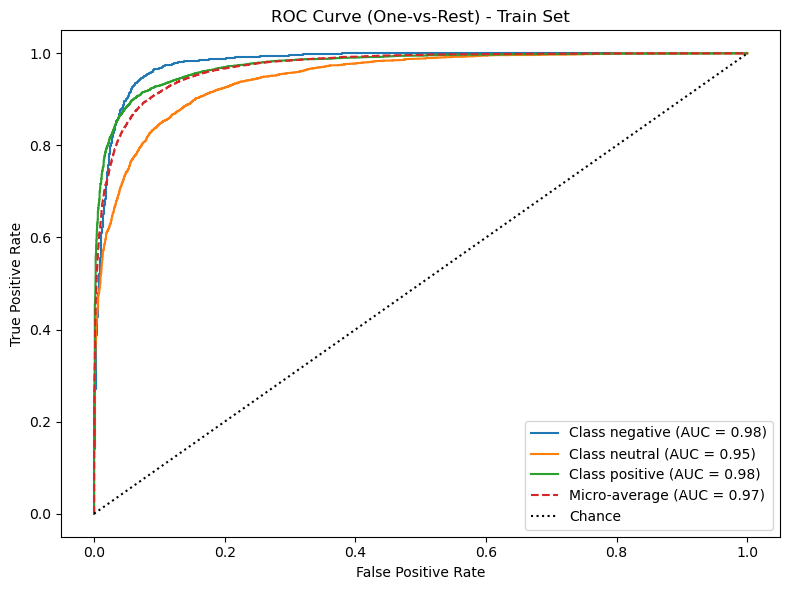

<Figure size 800x600 with 0 Axes>

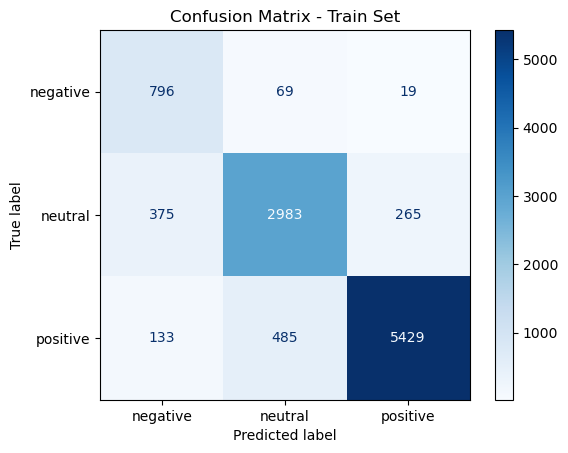

Classification report on test set:
              precision    recall  f1-score   support

           0       0.43      0.72      0.54       221
           1       0.75      0.70      0.73       906
           2       0.91      0.86      0.89      1512

    accuracy                           0.80      2639
   macro avg       0.70      0.76      0.72      2639
weighted avg       0.82      0.80      0.80      2639



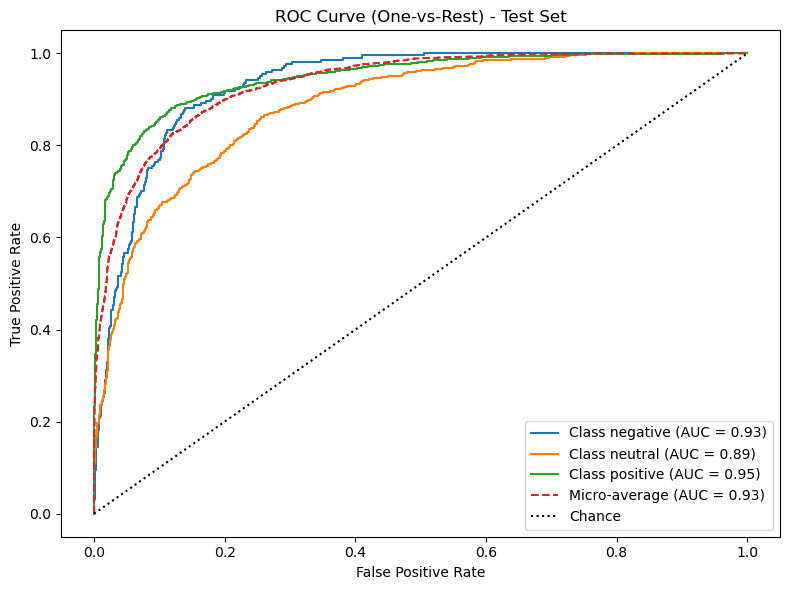

<Figure size 800x600 with 0 Axes>

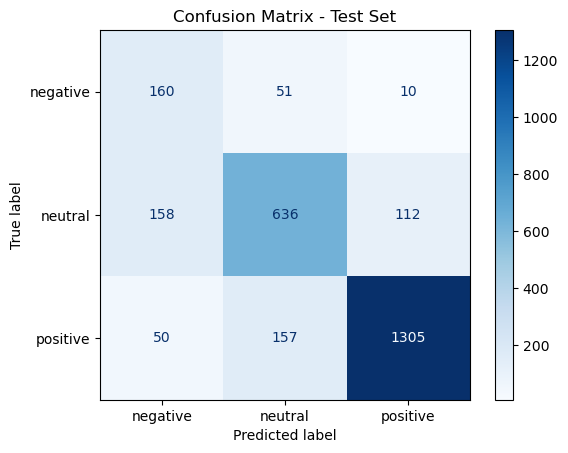

In [32]:
# Create pipeline with SMOTE
pipeline = ImbPipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=stem_tokenizer,  # Tokenize with custom stemmer function with error handling
                lowercase=True,
                max_features=5000,
                token_pattern=None,  # Explicitly disable default token pattern
            ),
        ),
        ("smote", SMOTE(random_state=42)),  # Handle class imbalance
        (
            "classifier",
            LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
        ),
    ]
)

# Define parameter grid for random search
param_dist = {
    "tfidf__max_features": [1000, 5000, 10000, None],  # Number of features
    "tfidf__ngram_range": [(1, 1), (1, 2)],  # Unigrams and bigrams
    "smote__k_neighbors": [3, 5, 7],  # Number of nearest neighbors
    "classifier__C": loguniform(1e-3, 100),  # Log-uniform distribution for C
    "classifier__solver": ["lbfgs", "liblinear", "sag"],  # Different solvers
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=5,  # Number of parameter combinations to try
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1,
)

# Perform random search on training data
print("Starting randomized grid search...")
random_search.fit(X_train, y_train)

# Best model from random search
best_model = random_search.best_estimator_

# Evaluate the best model
print("\nBest model evaluation:")
score["TF-IDF + LR"] = evaluate_model(
    best_model, X_train, y_train, X_test, y_test, le.classes_
)

**Random Forest**

Starting randomized grid search...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best model evaluation:
Train ROC AUC: 0.9778
Test ROC AUC: 0.8601
Classification report on train set:
              precision    recall  f1-score   support

           0       0.99      0.78      0.88       884
           1       0.84      0.93      0.89      3623
           2       0.96      0.92      0.94      6047

    accuracy                           0.91     10554
   macro avg       0.93      0.88      0.90     10554
weighted avg       0.92      0.91      0.92     10554



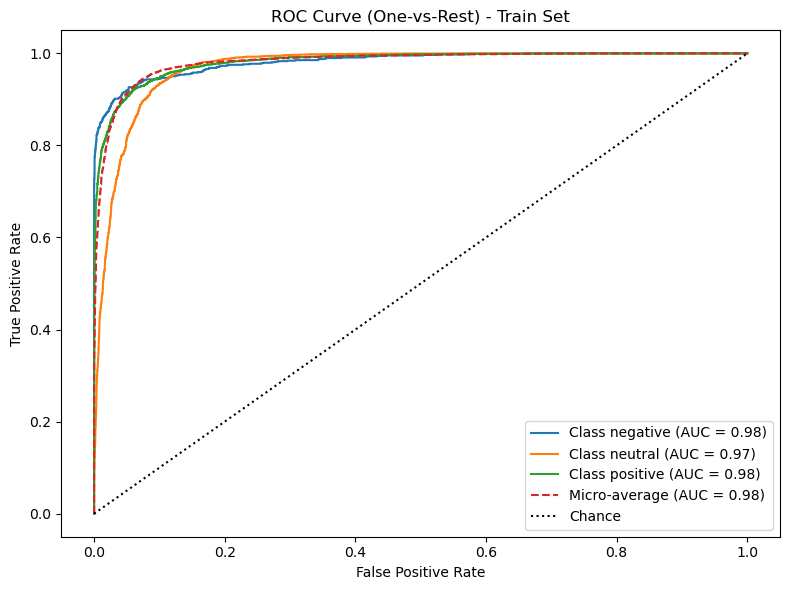

<Figure size 800x600 with 0 Axes>

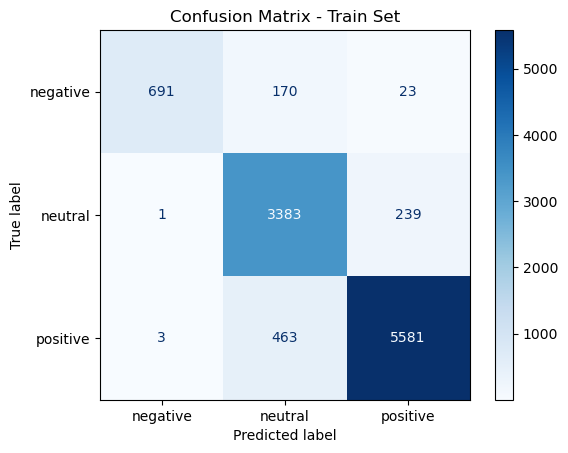

Classification report on test set:
              precision    recall  f1-score   support

           0       0.34      0.37      0.36       221
           1       0.69      0.70      0.69       906
           2       0.84      0.83      0.83      1512

    accuracy                           0.74      2639
   macro avg       0.62      0.63      0.63      2639
weighted avg       0.75      0.74      0.75      2639



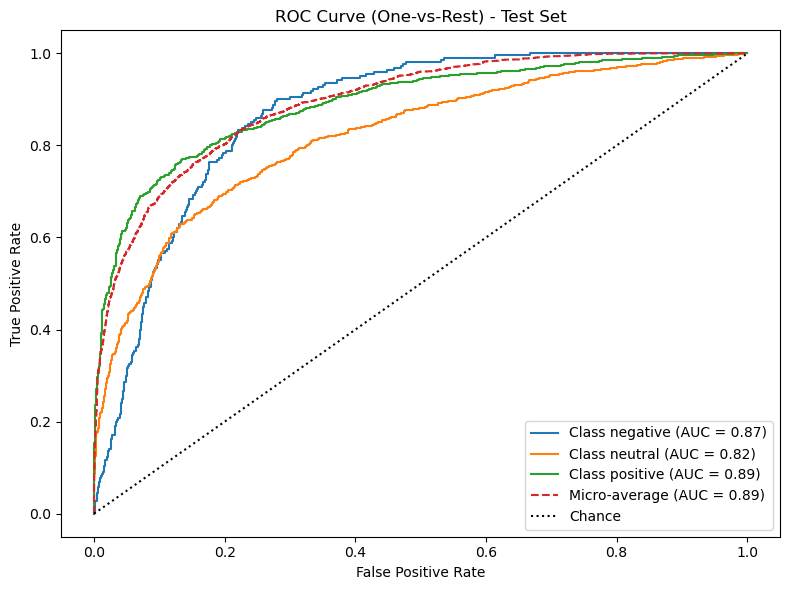

<Figure size 800x600 with 0 Axes>

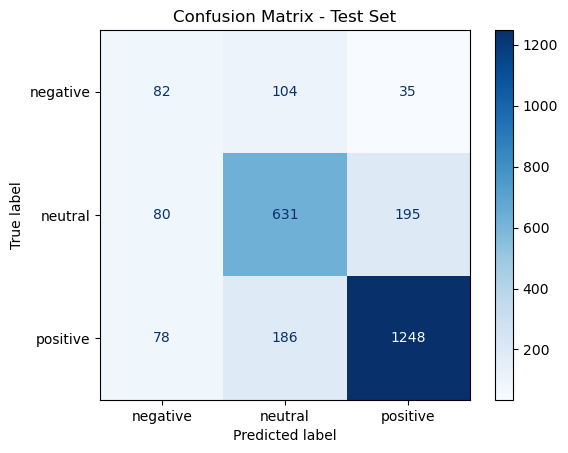

In [33]:
# Create pipeline with SMOTE
pipeline = ImbPipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=stem_tokenizer,  # Tokenize with custom stemmer function with error handling
                lowercase=True,
                max_features=5000,
                token_pattern=None,  # Explicitly disable default token pattern
            ),
        ),
        ("smote", SMOTE(random_state=42)),  # Handle class imbalance
        (
            (
                "classifier",
                RandomForestClassifier(class_weight="balanced", random_state=42),
            )
        ),
    ]
)

# Define parameter grid for random search
param_dist = {
    "tfidf__max_features": [5000, 10000],
    "tfidf__ngram_range": [(1, 1)],
    "smote__k_neighbors": [3, 5],
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5],
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=2,  # Number of parameter combinations to try
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1,
)

# Perform random search on training data
print("Starting randomized grid search...")
random_search.fit(X_train, y_train)

# Best model from random search
best_model = random_search.best_estimator_

# Evaluate the best model
print("\nBest model evaluation:")
score["TF-IDF + RF"] = evaluate_model(
    best_model, X_train, y_train, X_test, y_test, le.classes_
)

Starting training model...

Model evaluation:
Train ROC AUC: 0.9779
Test ROC AUC: 0.9129
Classification report on train set:
              precision    recall  f1-score   support

           0       0.88      0.68      0.77       884
           1       0.87      0.89      0.88      3623
           2       0.94      0.96      0.95      6047

    accuracy                           0.91     10554
   macro avg       0.90      0.84      0.87     10554
weighted avg       0.91      0.91      0.91     10554



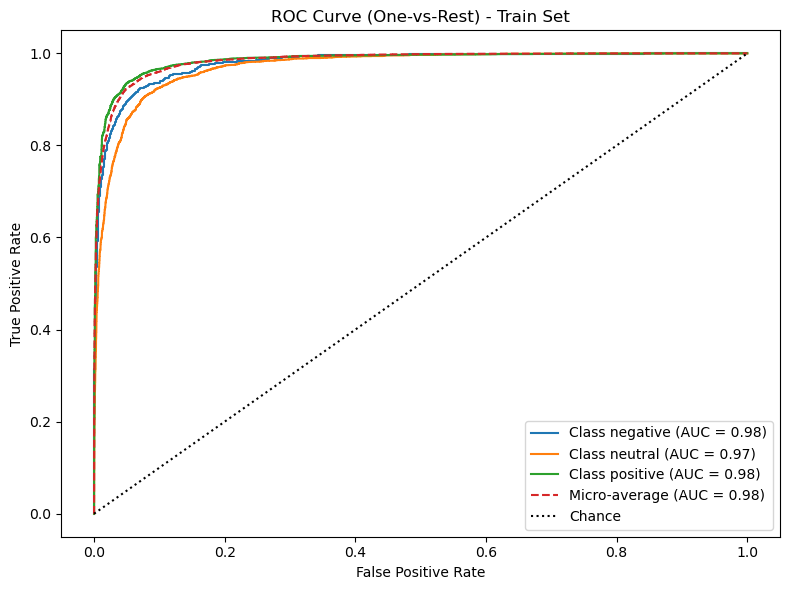

<Figure size 800x600 with 0 Axes>

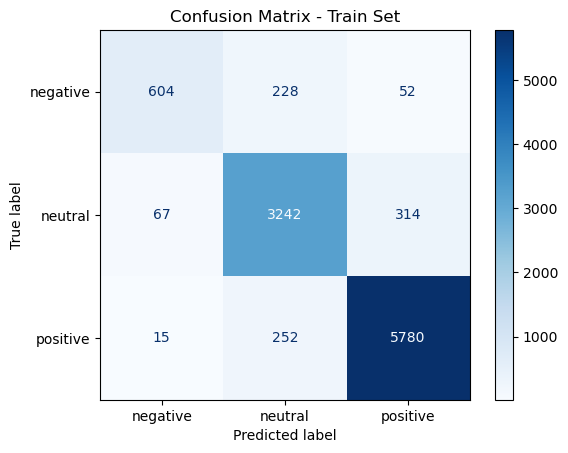

Classification report on test set:
              precision    recall  f1-score   support

           0       0.52      0.32      0.40       221
           1       0.71      0.73      0.72       906
           2       0.86      0.89      0.88      1512

    accuracy                           0.79      2639
   macro avg       0.70      0.65      0.66      2639
weighted avg       0.78      0.79      0.78      2639



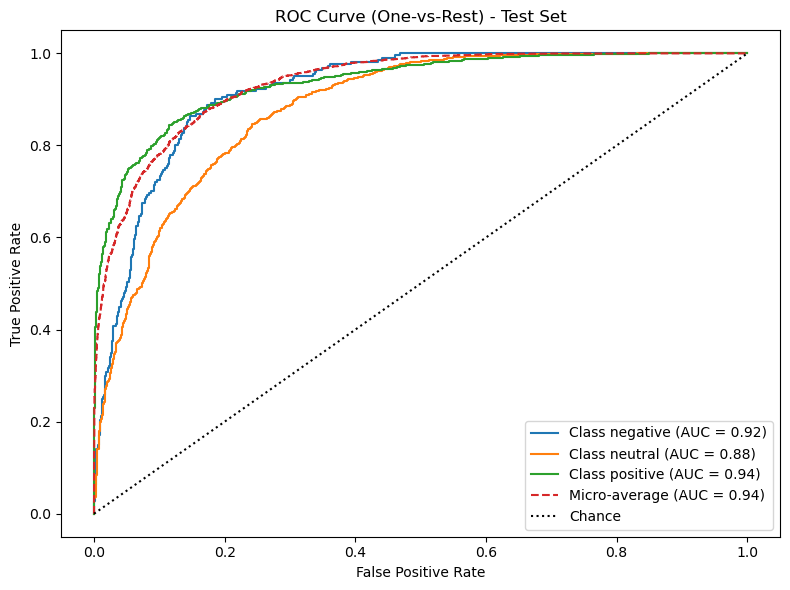

<Figure size 800x600 with 0 Axes>

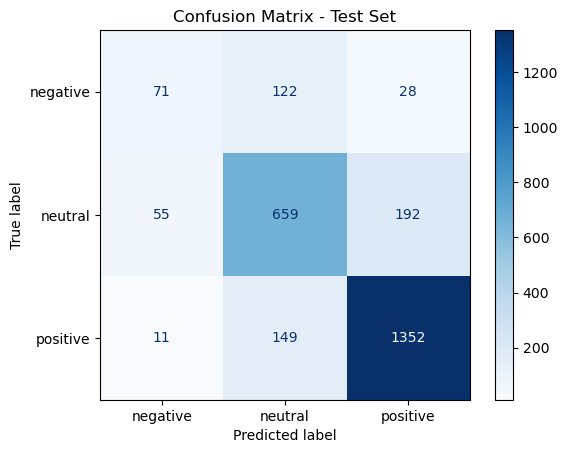

In [34]:
pipeline = ImbPipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=stem_tokenizer,  # Tokenize with custom stemmer function with error handling
                lowercase=True,
                max_features=5000,
                token_pattern=None,  # Explicitly disable default token pattern
            ),
        ),
        # ("smote", SMOTE(random_state=42)),  # Handle class imbalance
        (
            "classifier",
            MLPClassifier(max_iter=300, random_state=42, early_stopping=True),
        ),
    ]
)

# Perform random search on training data
print("Starting training model...")
model = pipeline.fit(X_train, y_train)

# Evaluate the best model
print("\nModel evaluation:")
score["TF-IDF + MLP"] = evaluate_model(model, X_train, y_train, X_test, y_test, le.classes_)

**Muti-nominal Naive Bayes**

Starting training model...

Model evaluation:
Train ROC AUC: 0.9099
Test ROC AUC: 0.8393
Classification report on train set:
              precision    recall  f1-score   support

           0       0.33      0.91      0.49       884
           1       0.79      0.42      0.55      3623
           2       0.85      0.86      0.85      6047

    accuracy                           0.72     10554
   macro avg       0.66      0.73      0.63     10554
weighted avg       0.78      0.72      0.72     10554



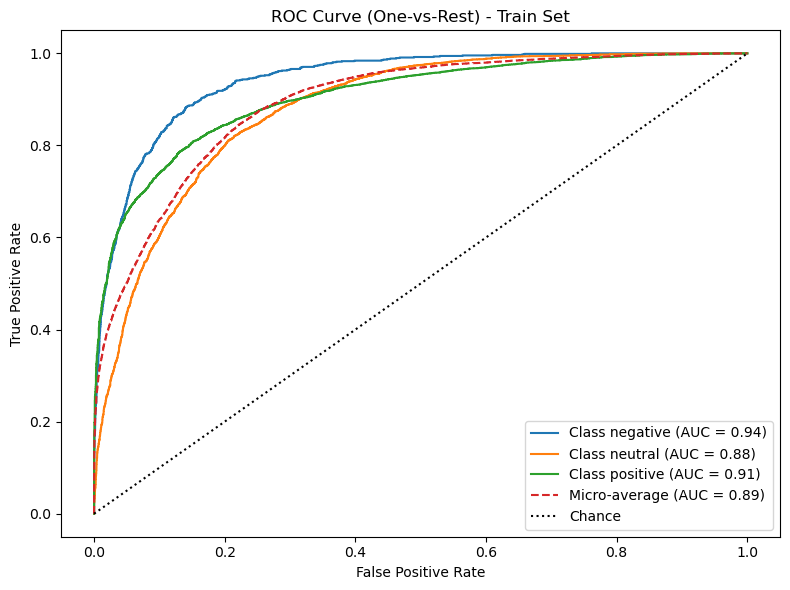

<Figure size 800x600 with 0 Axes>

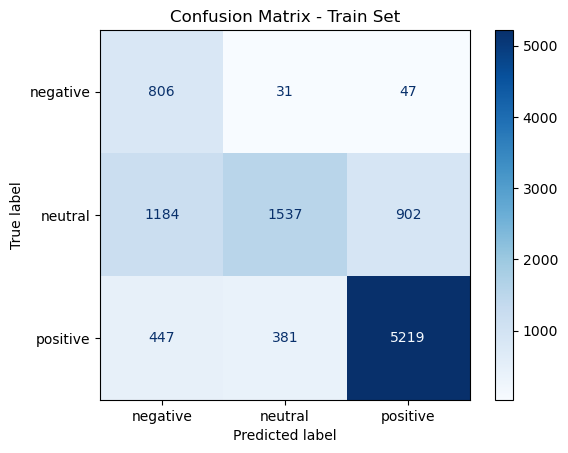

Classification report on test set:
              precision    recall  f1-score   support

           0       0.26      0.78      0.39       221
           1       0.61      0.27      0.38       906
           2       0.80      0.83      0.82      1512

    accuracy                           0.64      2639
   macro avg       0.56      0.63      0.53      2639
weighted avg       0.69      0.64      0.63      2639



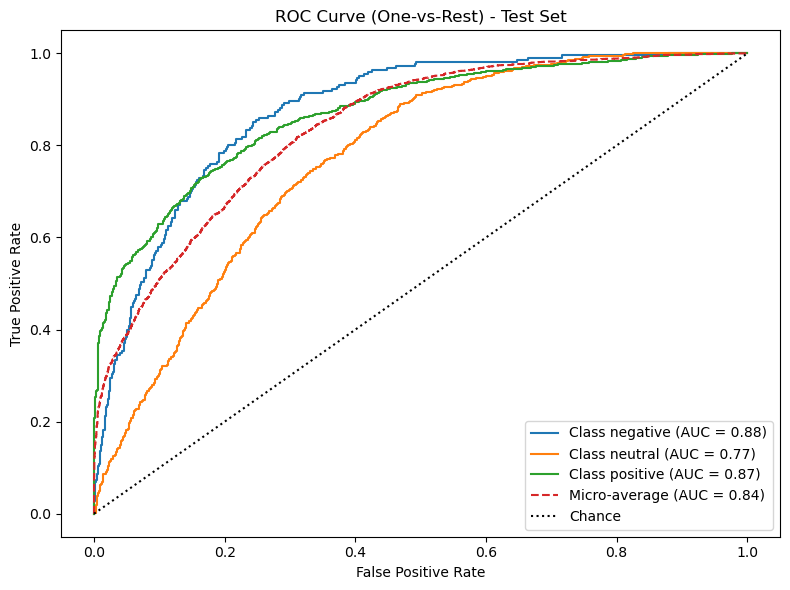

<Figure size 800x600 with 0 Axes>

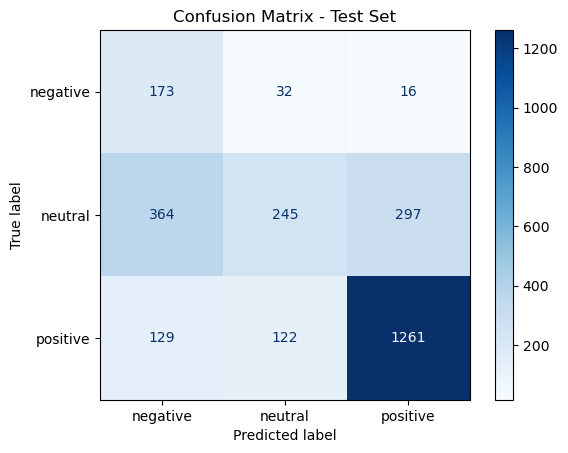

In [35]:
pipeline = ImbPipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=stem_tokenizer,  # Tokenize with custom stemmer function with error handling
                lowercase=True,
                max_features=5000,
                token_pattern=None,  # Explicitly disable default token pattern
            ),
        ),
        ("smote", SMOTE(random_state=42)),  # Handle class imbalance
        (
            "classifier",
            MultinomialNB(),
        ),
    ]
)

# Perform random search on training data
print("Starting training model...")
model = pipeline.fit(X_train, y_train)

# Evaluate the best model
print("\nModel evaluation:")
score["TF-IDF + MutinomialNB"] = evaluate_model(
    model, X_train, y_train, X_test, y_test, le.classes_
)

In [37]:
score

,GloVe + LR,GloVe + RF,W2V + SVM,W2V + XGBoost,TF-IDF + LR,TF-IDF + RF,TF-IDF + MLP,TF-IDF + MutinomialNB
Train Accuracy,0.735930,0.997347,0.769092,0.999716,0.872465,0.914819,0.912071,0.716506
Train Precision,0.723789,0.997349,0.702620,0.999716,0.885119,0.919719,0.911597,0.783221
Train Recall,0.735930,0.997347,0.769092,0.999716,0.872465,0.914819,0.912071,0.716506
Train F1,0.717300,0.997348,0.734116,0.999716,0.875992,0.915238,0.910702,0.719647
Train ROC AUC,0.873070,0.999880,0.895623,0.999953,0.967737,0.977843,0.977928,0.909861
Test Accuracy,0.707844,0.733611,0.738537,0.727548,0.796135,0.743085,0.788935,0.636226
Test Precision,0.691232,0.667846,0.673995,0.700744,0.819076,0.747609,0.779433,0.691569
Test Recall,0.707844,0.733611,0.738537,0.727548,0.796135,0.743085,0.788935,0.636226
Test F1,0.690040,0.697574,0.704423,0.707984,0.803843,0.745218,0.782016,0.629806
Test ROC AUC,0.842688,0.838130,0.859120,0.856333,0.922255,0.860097,0.912940,0.839279
